# [EX3] 카메라 스티커앱 만들기

### * 목표  
고양이 수염 스티커 적용

### * 목차
1. 라이브러리 import
2. 이미지 준비
3. 얼굴 검출
4. 랜드마크 검출
5. 스티커 적용 위치 확인
6. 바운딩 박스와 랜드마크 제거
7. 스티커 적용하기
8. 문제점 찾아보기



## 1. 라이브러리 import

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import dlib

print("import success")

import success


## 2. 이미지 준비

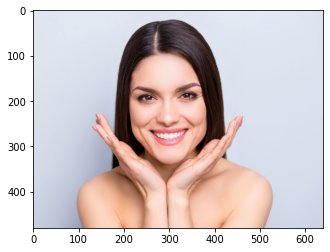

In [2]:
image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png' # 이미지 경로

img_bgr = cv2.imread(image_path) # OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480)) # 640x480의 크기로 Resize

img_bgr_add = img_bgr.copy()
img_show = img_bgr.copy() # 출력용 이미지 별도 보관

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # BGR -> RGB 색깔 보정처리

plt.imshow(img_rgb)
plt.show()

## 3. 얼굴 검출

#### 1) dlib를 이용해 hog detector 선언

In [3]:
detector_hog = dlib.get_frontal_face_detector() # detector 선언
print("hog detector success")

hog detector success


#### 2)  얼굴 bounding box 추출 및 출력

rectangles[[(201, 139) (386, 325)]]


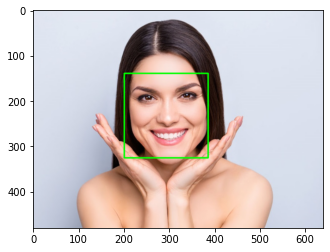

In [4]:
dlib_rects = detector_hog(img_rgb, 1) # dlib은 rgb 이미지를 입력으로 받으므로, bgr 이미지를 rgb로 변환
print(dlib_rects) # 찾은 얼굴 영역 좌표

for dlib_rect in dlib_rects: # dlib.rectangle 객체의 멤버 함수 사용
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show() # 결과 이미지 출력

## 4. 랜드마크 검출

#### 1) landmark 모델 불러오기

In [5]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("landmark_predictor success")

landmark_predictor success


#### 2) landmark 좌표 값 리스트 구현

In [6]:
# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
list_landmarks = [] # list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points) # list_points 는 tuple (x, y) 68개로 이루어진 리스트
    
print(len(list_landmarks[0])) # 랜드마크 검출 개수

68


#### 3) 랜드마크를 영상에 출력

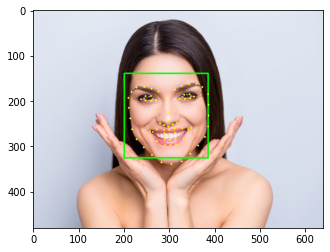

In [7]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show() # 결과 이미지 출력

## 5. 스티커 적용 위치 확인

#### 1) 스티커 위치 확인

In [8]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 33(코 아래)
    x = landmark[30][0] - dlib_rect.width()//2
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width() 
    print ('(x,y) : (%d,%d)'%(x,y)) # 스티커 중앙 좌표
    print ('(w,h) : (%d,%d)'%(w,h)) # 스티커 사이즈 크기

(297, 243)
(x,y) : (204,150)
(w,h) : (186,186)


#### 2) 스티커 resize

(186, 186, 3)


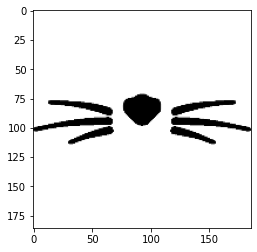

In [9]:
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) 
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
plt.imshow(img_sticker)

#### 3) 스티커 적용 및 출력

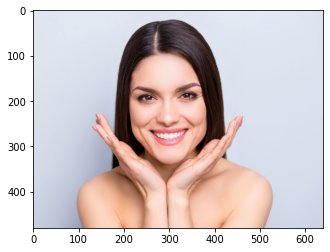

In [10]:
# 원본이미지에서 스티커를 적용할 위치를 crop한 이미지
sticker_area = img_show[y:y + img_sticker.shape[0], x:x + img_sticker.shape[1]]

# np.where 영역 지정
# np.where는 img_sticker가 0 인 부분은 sticker_area를 사용하고, 0이 아닌 부분을 img_sticker 사용
img_show[y:y + img_sticker.shape[0], x:x + img_sticker.shape[1]] = \
    np.where(img_sticker == 0,img_sticker, sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # img_show에 재적용
plt.show() # 결과 이미지 출력

## 6. 스티커 적용하기

#### 1) bounding box, landmark를 제거

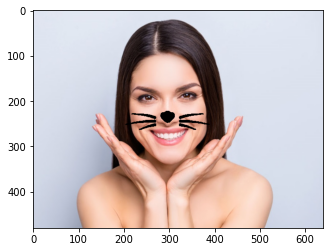

In [11]:
# bounding box와 landmark를 제거하고 최종 결과만 출력
sticker_area = img_bgr[y:y + img_sticker.shape[0], x:x + img_sticker.shape[1]]

img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker == 0,img_sticker, sticker_area).astype(np.uint8)
 
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # mg_rgb를 활용
plt.show()

#### 2)  스티커 투명도 조절

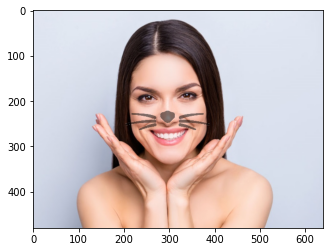

In [12]:
sticker_area = img_bgr_add[y:y + img_sticker.shape[0], x:x + img_sticker.shape[1]]

img_bgr[y:y + img_sticker.shape[0], x:x + img_sticker.shape[1]] = \
     cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker == 255,sticker_area,img_sticker).astype(np.uint8), 0.5, 0)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 7. 문제점 찾아보기 

#### 질문 1) 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?

* 회전한 얼굴 각도에 맞추어 중심 값(코 끝)을 지정 해주고, 그 값을 기준으로 이미지 회전 및 사이즈 조절하면 될 것 같다.      
* openCV에서 제공하는 cv2.getRotationMatrix2D() 함수를 이용하면, 중앙을 기점으로 이미지를 회전 할 수 있다.
* 회고 : 회전 스티커 적용시, 회전 후 보이는 검은색 배경까지 같이 적용되어버렸다. 배경 삭제 방법을 찾아봐야겠다.    

(186, 186, 3)


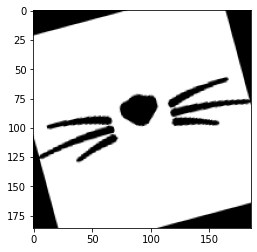

In [13]:
# cv2.getRotationMatrix2D 함수를 이용한 이미지 회전
img_sticker_ro = cv2.imread(sticker_path)

height, width, channel = img_sticker_ro.shape
matrix = cv2.getRotationMatrix2D((h/2, w/2), 15, 1) # 15도 돌리고 스케일 요소 1
dst = cv2.warpAffine(img_sticker, matrix, (h, w))

img_sticker_ro = cv2.resize(img_sticker_ro, (w,h)) # resize

print (dst.shape)
plt.imshow(cv2.cvtColor(dst,cv2.COLOR_BGR2RGB))
plt.show()

#### 질문 2) 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
* 동일한 이미지로 어둡게, 밝게, 늘려서 테스트 해본 결과, 랜드마크를 정확히 인식하지 못하였다.
* 그 이유는, dlib 의 HOG은 gradient를 feature로 사용하는데,      
영역 단위의 밝기차를 이용하기 때문에, contrast 변화, 광원의 방향 변화에 따른 영상 밝기 변화에 영향을 받으며,    
(멀리서 촬영하거나, 누워 찍은 얼굴 등) 물체가 회전된 경우에는 검출이 힘들다고 한다.    
[참고] https://darkpgmr.tistory.com/116 

#### 질문 3) 실행 속도가 중요할까요? 

* 스티커앱처럼 얼굴에 스티커 붙히는 정도의 기능으로는 실행 속도가 빠르지 않아도 될 것 같다.
* HOG은 실행 속도가 빠르지 않지만, 얼굴 식별 등에 뛰어난 알고리즘으로 스티커앱 구현에 적합한 알고리즘이고 생각된다.    
[참고] https://darkpgmr.tistory.com/53

#### 질문 4) 스티커앱을 만들 때 정확도가 얼마나 중요할까요?    

* 스티커앱의 정확도는 매우 중요하다고 생각된다. 속도는 빠르지 않지만, 정확한 기능을 서비스한다면 사용자들은 만족할 것이라 생각된다.
* 2)번과 같은 이유로 HOG은 이에 적합한 알고리즘이라 생각된다.      
[참고] https://darkpgmr.tistory.com/53